# 线性回归

In [1]:
# 经典统计学习技术中的线性回归和softmax回顾可以视为线性神经网络

## 矢量加速

In [2]:
# 在训练我们的模型时，同时处理整个小批量样本，因此需要对计算进行矢量化，利用线性代数库

In [5]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [6]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [3]:
from d2l import save

In [5]:

class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        """启动计时器"""
        self.tik = time.time()
        
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """返回平均时间"""
        return sum(self.times)/len(self.times)
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [6]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.09926 sec'

In [12]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

In [26]:
# d2l文件目录下有一个Timer.py的文件中，定义了一个Timer类，以下是调用语法
from d2l.Timer import Timer

In [25]:
timer = Timer()

In [27]:
import matplotlib.pyplot as plt

In [7]:
# 定义一个Python函数来计算正态分布
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

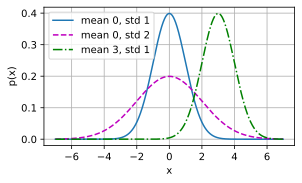

In [10]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准对
params = [(0, 1), (0, 2), (3, 1)]
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
        
         ylabel='p(x)', figsize=(4.5, 2.5),
        legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

In [11]:
# 为了防止库文件冲突导致内核挂掉，应该加入如下代码
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [12]:
# 机器学习模型中的关键要素是训练数据、损失函数、优化算法，还有模型本身
# 矢量化使数学表达上更简洁，同时运行的更快
# 最小化目标函数和执行极大似然估计等价
# 线性回归模型也是一个简单的神经网络

## 线性回归的从零开始

In [13]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 生成数据集

In [14]:
# 生成数据集
# 使用模型参数w=[2, -3.4],b=4.2和噪声项ϵ
# ϵ可以视为模型预测和标签时的潜在误差，在这里我们认为标准假设成立，即ϵ服从均值为0的正态分布
# 为了简化问题，我们将标准差设为0.01

In [17]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [18]:
print('feature:',features[0], '\nlabel:', labels[0])

feature: tensor([-0.9477,  0.0023]) 
label: tensor([2.2916])


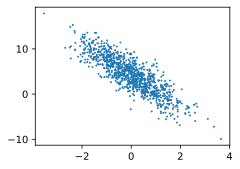

In [19]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
# .detach()函数的作用将张量从计算图中分离，返回一个新的张量，新的张量不再具有梯度信息

### 读取数据集

In [21]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [22]:
# 通常，我们利用GPU并行运算的优势，处理合理大小的‘小批量’
# 每个样本损失函数的梯度也可以被并行计算，GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多

In [23]:
# 我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。
# 每个批量的特征维度显示批量批量大小和输入特征数

In [24]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0697, -0.0140],
        [-0.1620,  0.7378],
        [-1.0428, -0.6852],
        [ 0.0166,  1.0462],
        [-1.5871, -1.7896],
        [-1.8330, -1.8939],
        [-0.6139,  0.3991],
        [-0.0833,  1.1221],
        [ 0.0506,  2.2384],
        [ 0.3061, -0.3723]]) 
 tensor([[ 4.3764],
        [ 1.3634],
        [ 4.4476],
        [ 0.6688],
        [ 7.1043],
        [ 6.9626],
        [ 1.6112],
        [ 0.2285],
        [-3.3078],
        [ 6.0782]])


In [25]:
# 当我们运行迭代时，我们会连续地获得不同地小批量，直至遍历完整个数据集。
# 上面实现的迭代对教学来说很好，但是它的执行效率很低，可能会在实际问题上陷入麻烦。
# 例如它要求我们将所有数据加载到内存中，并执行大量的随机内存访问
# 在深度学习框架中实现的内置迭代器效率要高的多，它可以处理存储在文件中的数据和数据流提供的数据

### 初始化模型参数

In [26]:
# 在我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要先有一些参数
# 从均值为0，标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 定义模型

In [29]:
# d2l.linreg(X, w, b)
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数

In [30]:
# d2l.squared_loss(y_hat, y)
# 均方误差
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法

In [31]:
# d2l.sgd(params, lr, batch_size)
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练

In [32]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [33]:
# 每个epoch都是把训练样本分成小批量样本进行一次训练更新参数
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1),而不是一个标量。l中的所有元素被加到一起
        # 并以此计算关于[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad(): # 禁用梯度计算
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1}, loss {float(train_l.mean()):f}')

epoch1, loss 0.031465
epoch2, loss 0.000104
epoch3, loss 0.000046


In [34]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 0.0001, -0.0003], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0001], grad_fn=<RsubBackward1>)


In [35]:
# python 中的+= 和 +
data = 1
print(id(data))
data += 1
print(id(data))

2905827928368
2905827928400


In [36]:
data = 1
print(id(data))
data = data + 1
print(id(data))

2905827928368
2905827928400


In [37]:
a = torch.ones((2, 1))

In [38]:
a

tensor([[1.],
        [1.]])

In [41]:
# PyTorch中的 += 和 +
print(id(a))
a += 1
print(id(a))

2906230064048
2906230064048


In [42]:
print(id(a))
a = a + 1
print(id(a))

2906230064048
2906193272240


## 线性回归的简洁实现

In [43]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [45]:
# 生成数据集
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [46]:
# 读取数据集
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [47]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[ 0.0420, -0.3628],
         [ 0.3029,  1.7162],
         [-1.0956,  1.9379],
         [-1.0161, -1.5979],
         [ 0.6071, -1.8488],
         [-1.6996, -0.0481],
         [ 0.8580, -0.2232],
         [ 0.3542, -0.7338],
         [ 1.8070,  0.2535],
         [-0.1024,  0.0763]]),
 tensor([[ 5.5090],
         [-1.0233],
         [-4.5687],
         [ 7.5944],
         [11.7018],
         [ 0.9792],
         [ 6.6721],
         [ 7.4162],
         [ 6.9524],
         [ 3.7408]])]

### 定义模型

In [48]:
# nn是神经网络的缩写
from torch import nn

In [50]:
net = nn.Sequential(nn.Linear(2, 1))
# （2， 1）该模型具有2个输入特征，1个输出特征

### 初始化模型参数

In [51]:
# 还是指定每个参数应该从均值为0，标准差为0.01的正态分布中随机采样，偏置参数将初始化为0
# 通过net[0]来访问网络的第一个图层，然后使用weight.data和bias.data方法访问参数
# 我们还可以使用normal_和fill_来重写参数值

In [52]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数

In [53]:
# 计算均方误差使用的是MSELoss类，也称为平方L2范数。默认情况下，它返回所有样本损失的平均值
loss = nn.MSELoss()

### 定义优化算法

In [54]:
# 小批量随机梯度下降(SGD)算法是一种优化nn的标准工具，PyTorch在optim模块中实现了该算法的许多变种
# 当我们实例化一个SGD实例时，我们要指定优化的参数（可以通过net.parameters()从我们的模型中获得）
# 以及优化算法所需的超参数字典。
# 小批量随机梯度下降只需要设置lr值，这里设置为0.03

In [56]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)
# 优化算法就是用来更新参数的

### 训练

In [59]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()  # 将模型参数梯度清零
        l.backward()
        trainer.step()  # 更新参数
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000105
epoch 2, loss 0.000105
epoch 3, loss 0.000105


In [60]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的误差：', true_b - b)

w的估计误差： tensor([-0.0003, -0.0002])
b的误差： tensor([4.0531e-05])


## softmax回归

## 图像分类数据集

In [1]:
# MNIST数据集是图像分类中广泛使用的数据集之一，但作为基准数据过于简单。我们将使用
# 类似但更复杂的Fashion-MINIST数据集

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

### 读取数据集

In [3]:
# 通过ToTensor实例将图像数据从PIL类型转换成32位浮点数格式
# 并除以255使得所有像素的数值均在0-1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [4]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [5]:
# 每个输入图像的高度和宽度均为28像素，通道数为1
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [6]:
# Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤⼦）、pullover（套衫）
# dress（连⾐裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。
# 以下函数⽤于在数字标签索引及其⽂本名称之间进⾏转换。
# d2l.get_fashion_mnist_labels(labels)
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [7]:
# 我们可以创建一个函数来可视化这些样本
# d2l.show_images(imgs, num_rows, num_cols, titles=None, scale=1.5)
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten() # 可以方便处理多个子图，而不是用二维的索引
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False) # 隐藏x轴刻度和标签
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

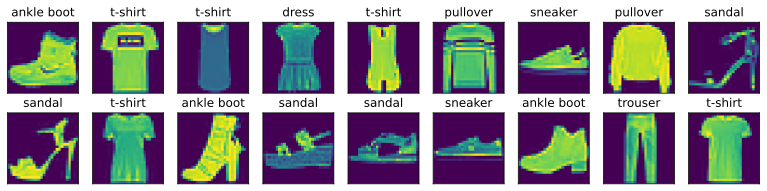

In [8]:
# 一下是训练数据集中前几个样本的图像及其相应的标签
# 创建一个用于批量加载数据的数据加载器(DataLoader)对象
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

### 读取小批量

In [9]:
batch_size = 256

# d2l.get_dataloader_workers()
def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())


In [10]:
# 我们看一下读取训练数据所需的时间
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'3.31 sec'

In [19]:
a = iter([1,2,3])

In [20]:
next(a)

1

### 整合所有组件

In [21]:
# d2l.load_data_fashion_mnist()
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans) # 将多个转换操作合并到一块儿
    mnist_train = torchvision.datasets.FashionMNIST(
        root='../data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root='../data', train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                           num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                           num_workers=get_dataloader_workers()))

In [22]:
# 下面我们通过指定resize参数来测试load_data_fashion_mnist函数的图像大小调整功能
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [23]:
type(mnist_train)

torchvision.datasets.mnist.FashionMNIST

In [28]:
type(X)

torch.Tensor

In [30]:
X.shape

torch.Size([32, 1, 64, 64])

In [31]:
type(y)

torch.Tensor

In [32]:
y.shape

torch.Size([32])

## softmax回归的从零开始实现

In [37]:
import torch
from IPython import display
from d2l import torch as d2l

In [38]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 初始化模型参数

In [39]:
# 这里的每个样本都将用固定长度的向量表示。原始数据集中的每个样本都是28×28的图像
# 本节将展平每个图像，把它们看作长度为784的向量。
# 因为我们的数据集有10个类别，所以网络输出维度为10.因此，权重将构成一个784×10的矩阵，偏置将构成一个1×10的行向量。
# 与线性回归一样，我们将使用正态分布初始化我们的权重w，偏置初始化为0
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [40]:
W.shape

torch.Size([784, 10])

In [41]:
b.shape

torch.Size([10])

### 定义softmax操作

In [42]:
# sum运算符
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [43]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播的机制

In [45]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1, keepdim=True)

(tensor([[0.2696, 0.1184, 0.3859, 0.0948, 0.1314],
         [0.2058, 0.0860, 0.0667, 0.0233, 0.6181]]),
 tensor([[1.0000],
         [1.0000]]))

### 定义模型

In [46]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [47]:
X = torch.ones((2, 3))

In [48]:
X.shape

torch.Size([2, 3])

In [49]:
X.reshape((-1, 2))

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

### 定义损失函数

In [54]:
# y为样本概率中的索引下标，y_hat为不同类别的概率
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [55]:
# 实现交叉熵损失函数
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 分类精度

In [59]:
# y_hat是预测概率分布，但是我们必须输出预测概率最高对应的类。
# 当预测与标签分类y一致时，即是正确的。分类精度即正确预测数量/总预测数量
# d2l.accuracy()
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [60]:
y_hat

tensor([[0.1000, 0.3000, 0.6000],
        [0.3000, 0.2000, 0.5000]])

In [61]:
y

tensor([0, 2])

In [62]:
accuracy(y_hat, y) / len(y)

0.5

In [63]:
# 同样，对于任意数据迭代器data_iter可访问的数据集，我们可以评估在任意模型net的精度
# d2l.evaluate_accuracy()
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数，预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [64]:
# 这里定义一个实用程序类Accumulator,用于对多个变量进行累加。
# d2l.Accumulator()
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [65]:
evaluate_accuracy(net, test_iter)

0.0819

In [66]:
type(net)

function

### 训练

In [ ]:
# 在这里我们重构训练过程的实现以使其可重复使用。
# 首先我们定义一个函数来训练一个迭代周期，updater是更新模型参数的常用函数，如SGD等
# d2l.train_epoch_ch3()
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    